In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [51]:
# Load the CSV file into a DataFrame
file_path = 'retailer.csv'  # Update with your file's correct path
df_retailer = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify
display(df_retailer.head(10))

,customer_id,timestamp_utc,event_name,brand,product_name,sales,quantity
0,reFs5GI87lXJkJSi9r,2024-02-07 02:27:10,Product Page View,NaN,NaN,NaN,NaN
1,reFs5GI87lXJkJSi9r,2024-06-12 16:16:54,Product Page View,Science Diet,SD Fel A7+ SavCknEnt 24x5.5oz cs,NaN,NaN
2,reTjziox2cSrxVq70Y,2024-02-28 04:11:46,Product Page View,NaN,NaN,NaN,NaN
3,reTjziox2cSrxVq70Y,2024-02-28 04:30:42,Product Page View,Science Diet,SD Fel Adt HBC OFEnt 24x5.5oz cs,NaN,NaN
4,reOrpt9vhSwhbPVtni,2024-06-01 22:22:30,Product Page View,NaN,NaN,NaN,NaN
5,reOrpt9vhSwhbPVtni,2024-06-01 22:36:26,Product Page View,Science Diet,SD Ca Adt Lt Ckn 30lb bg,NaN,NaN
6,reOrpt9vhSwhbPVtni,2024-06-01 22:43:07,Product Page View,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN
7,reOrpt9vhSwhbPVtni,2024-06-20 14:02:48,Product Page View,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN
8,reOrpt9vhSwhbPVtni,2024-06-06 10:38:51,Order,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,19.99,1.0
9,reOrpt9vhSwhbPVtni,2024-06-01 22:47:09,Add to cart,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN


In [52]:
print(len(df_retailer))

9866049


# Missing Values

In [53]:
print(df_retailer.dtypes)

customer_id       object
timestamp_utc     object
event_name        object
brand             object
product_name      object
sales            float64
quantity         float64
dtype: object


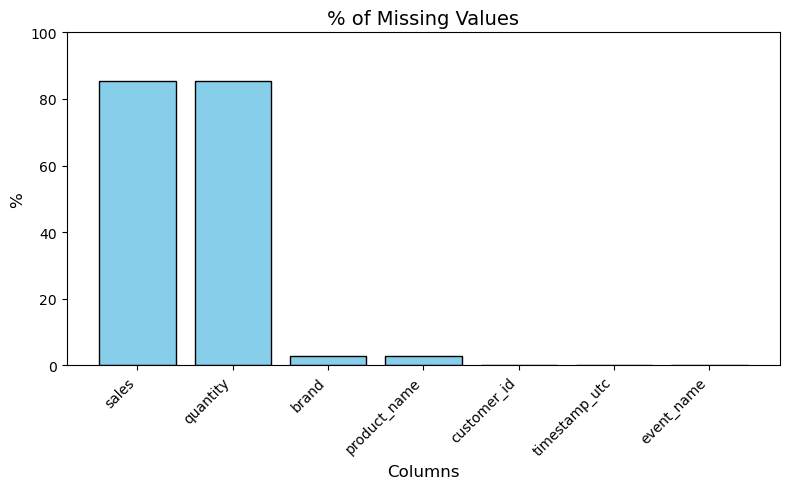

               Missing Count  Missing Percentage (%)
sales                8426738               85.411475
quantity             8426738               85.411475
brand                 277240                2.810041
product_name          277240                2.810041
customer_id                0                0.000000
timestamp_utc              0                0.000000
event_name                 0                0.000000


In [54]:
def count_missing_values_summary(df):
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_columns = missing_counts[missing_counts > 0]
    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percentage}
    ).sort_values(by='Missing Count', ascending=False)
    
    # Create the histogram
    plt.figure(figsize=(8, 5))
    plt.ylim(0, 100)
    plt.bar(missing_summary.index, missing_summary['Missing Percentage (%)'], color='skyblue', edgecolor='black')
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('%', fontsize=12)
    plt.title('% of Missing Values', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return missing_summary

# Example usage
summary = count_missing_values_summary(df_retailer)
print(summary)

## Data Types - Numeric

In [55]:
print("\nDescriptive statistics for 'sales':")
print(df_retailer['sales'].describe())

print("\nDescriptive statistics for 'quantity':")
print(df_retailer['quantity'].describe())


Descriptive statistics for 'sales':
count    1.439311e+06
mean     4.337350e+01
std      2.761782e+01
min      0.000000e+00
25%      2.248000e+01
50%      4.187000e+01
75%      5.599000e+01
max      1.184700e+03
Name: sales, dtype: float64

Descriptive statistics for 'quantity':
count    1.439311e+06
mean     1.081074e+00
std      4.033814e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.000000e+01
Name: quantity, dtype: float64


#### 'sales' and 'quantity' in correlation to 'event_name', to figure out where the missing values are listed

In [59]:
# List all unique attributes in the 'event_name' column
unique_event_names = df_retailer['event_name'].unique()

# Print the unique event names
print("Unique event_name attributes:")
print(unique_event_names)

# Group by 'event_name' and count missing values in 'sales'
nan_sales_by_event = df_retailer[df_retailer['sales'].isnull()].groupby('event_name').size()

print("Missing sales counts by event_name:")
print(nan_sales_by_event)

Unique event_name attributes:
['Product Page View' 'Order' 'Add to cart']
Missing sales counts by event_name:
event_name
Add to cart          2050111
Product Page View    6376627
dtype: int64


Proportion of missing sales by event_name (in %):
event_name
Add to cart          100.0
Order                  NaN
Product Page View    100.0
dtype: float64
                       sales  quantity  event_count
event_name                                         
Add to cart              NaN       NaN      2050111
Order              43.373495  1.081074      1439311
Product Page View        NaN       NaN      6376627


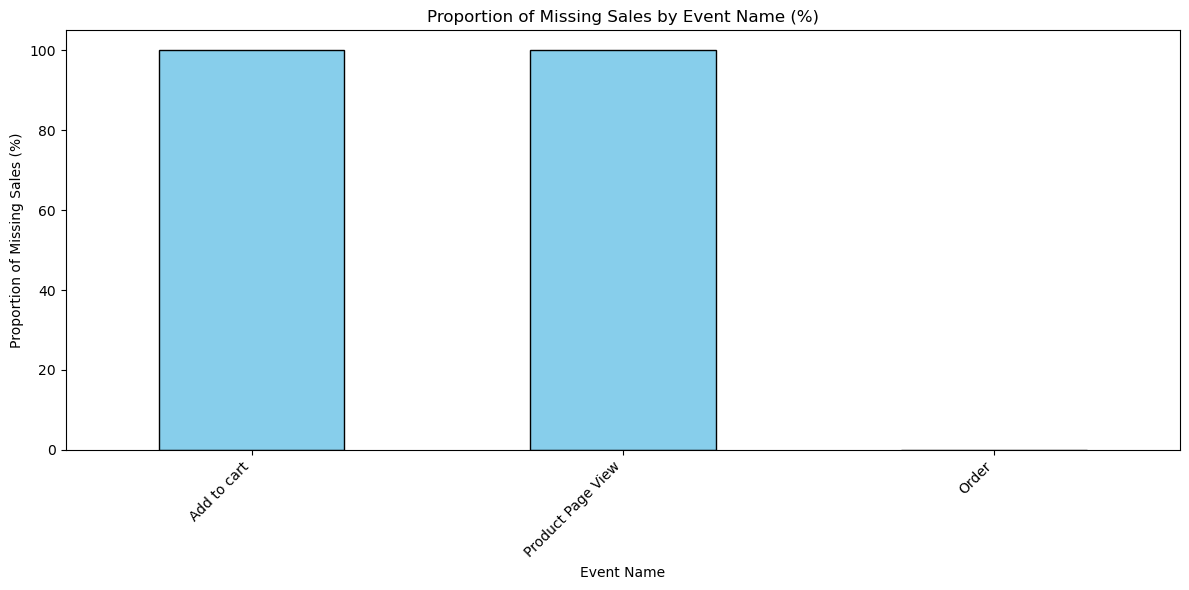

In [60]:
# Calculate the total rows per 'event_name'
total_by_event = df_retailer.groupby('event_name').size()

# Proportion of missing 'sales' per 'event_name' (in percentage)
missing_sales_proportion = (nan_sales_by_event / total_by_event) * 100
print("Proportion of missing sales by event_name (in %):")
print(missing_sales_proportion)

event_summary = df_retailer.groupby('event_name').agg({
    'sales': 'mean',
    'quantity': 'mean',
    'event_name': 'count'
}).rename(columns={'event_name': 'event_count'})

print(event_summary)

# Sort values for better visualization
missing_sales_proportion = missing_sales_proportion.sort_values(ascending=False)

# Plot the proportions
missing_sales_proportion.plot(kind='bar', figsize=(12, 6), color='skyblue', edgecolor='black')
plt.title('Proportion of Missing Sales by Event Name (%)')
plt.ylabel('Proportion of Missing Sales (%)')
plt.xlabel('Event Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

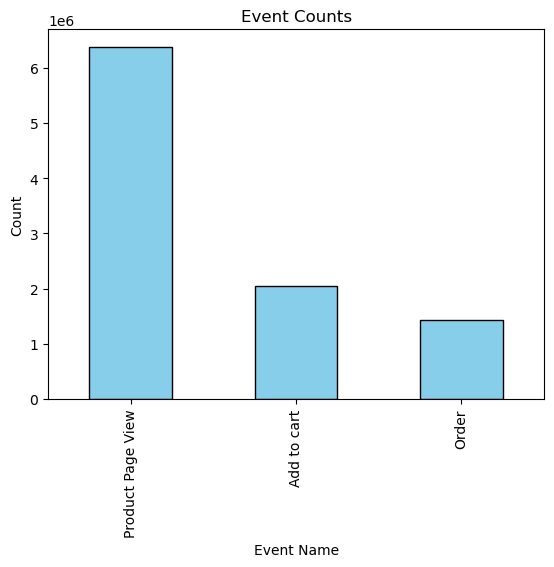

In [61]:
event_counts = df_retailer['event_name'].value_counts()
event_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Event Counts')
plt.xlabel('Event Name')
plt.ylabel('Count')
plt.show()

### Decision: Replace missing (NaN) values in the sales and quantity columns with 0

In [63]:
# Impute missing values for non-transactional events
df_retailer.loc[df_retailer['event_name'] != 'Order', ['sales', 'quantity']] = df_retailer.loc[
    df_retailer['event_name'] != 'Order', ['sales', 'quantity']
].fillna(0)

In [64]:
event_summary = df_retailer.groupby('event_name').agg({
    'sales': 'mean',
    'quantity': 'mean',
    'event_name': 'count'
}).rename(columns={'event_name': 'event_count'})

print(event_summary)

                       sales  quantity  event_count
event_name                                         
Add to cart         0.000000  0.000000      2050111
Order              43.373495  1.081074      1439311
Product Page View   0.000000  0.000000      6376627


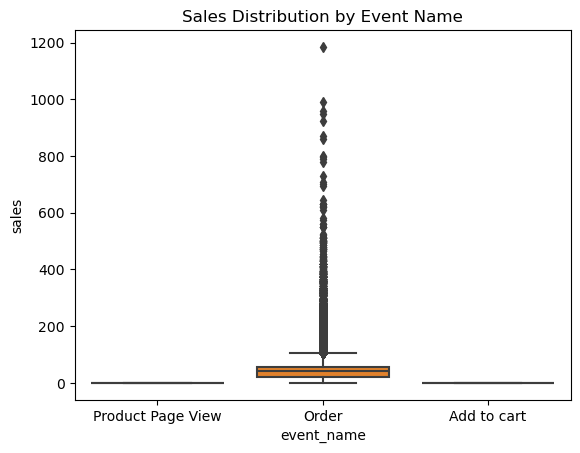

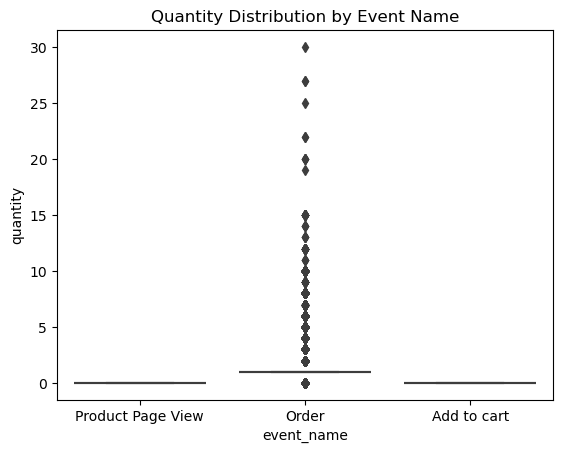

In [66]:
import seaborn as sns

sns.boxplot(x='event_name', y='sales', data=df_retailer)
plt.title('Sales Distribution by Event Name')
plt.show()

sns.boxplot(x='event_name', y='quantity', data=df_retailer)
plt.title('Quantity Distribution by Event Name')
plt.show()

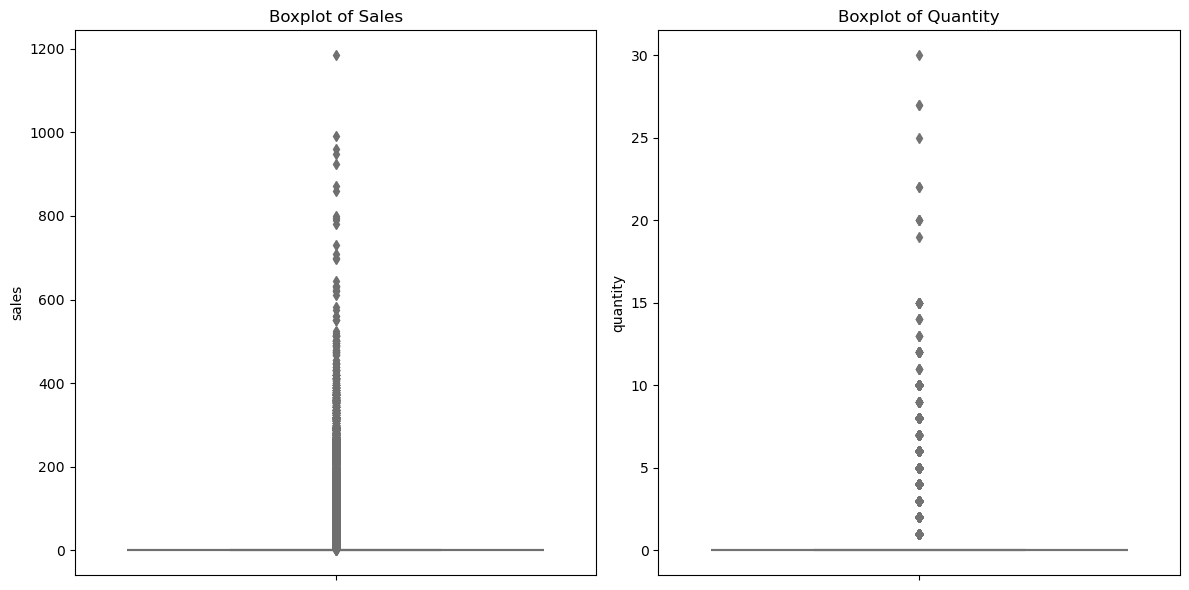

In [79]:
# Plot boxplots for 'sales' and 'quantity'
plt.figure(figsize=(12, 6))

# Boxplot for sales
plt.subplot(1, 2, 1)
sns.boxplot(y=df_retailer['sales'], color='skyblue')
plt.title('Boxplot of Sales')

# Boxplot for quantity
plt.subplot(1, 2, 2)
sns.boxplot(y=df_retailer['quantity'], color='lightgreen')
plt.title('Boxplot of Quantity')

plt.tight_layout()
plt.show()

In [82]:
# Function to identify outliers
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in 'sales' and 'quantity'
sales_outliers, sales_lower, sales_upper = detect_outliers(df_retailer, 'sales')
quantity_outliers, quantity_lower, quantity_upper = detect_outliers(df_retailer, 'quantity')

# Print the results
print(f"Sales outliers:\n{sales_outliers}")
print(f"Lower bound for sales: {sales_lower}, Upper bound for sales: {sales_upper}\n")

print(f"Quantity outliers:\n{quantity_outliers}")
print(f"Lower bound for quantity: {quantity_lower}, Upper bound for quantity: {quantity_upper}")

Sales outliers:
                customer_id        timestamp_utc event_name         brand  \
8        reOrpt9vhSwhbPVtni  2024-06-06 10:38:51      Order  Science Diet   
18       reutQ3jiBX9Li4Ggqi  2024-06-07 11:48:47      Order  Science Diet   
207                 unknown  2024-04-13 00:50:50      Order  Science Diet   
344      reDzpCoOpWJc5l9K3y  2024-03-02 19:42:22      Order  Science Diet   
345      reDzpCoOpWJc5l9K3y  2024-04-18 12:27:36      Order  Science Diet   
...                     ...                  ...        ...           ...   
9865700  reypdmZz1CIhFsWSf7  2024-06-19 00:56:35      Order  Science Diet   
9865702  relyf2wXitGcdWECun  2024-05-28 01:51:55      Order  Science Diet   
9865704  re3PPgNUNmZHgpVup1  2024-02-07 03:33:14      Order  Science Diet   
9865706  reepFoP0vHcREJs9sQ  2024-05-22 17:00:14      Order  Science Diet   
9865708  reDSwXWpyonbNwH7Sz  2024-03-14 13:01:24      Order  Science Diet   

                       product_name  sales  quantity  
8   

In [83]:
# Calculate percentages of outliers
sales_outliers_percentage = len(sales_outliers) / len(df_retailer) * 100
quantity_outliers_percentage = len(quantity_outliers) / len(df_retailer) * 100

print(f"Percentage of sales outliers: {sales_outliers_percentage:.2f}%")
print(f"Percentage of quantity outliers: {quantity_outliers_percentage:.2f}%")

Percentage of sales outliers: 14.52%
Percentage of quantity outliers: 14.56%


### Analzse 'event_name' in comparison to 'customer_id'

In [67]:
# Group by 'customer_id' and 'event_name' to count events
customer_event_counts = df_retailer.groupby(['customer_id', 'event_name']).size().reset_index(name='event_count')

# Preview the results
print(customer_event_counts.head())

          customer_id         event_name  event_count
0  re0007V8sqIHsZnbvC  Product Page View            2
1  re000JYhnKbTkPqMB4        Add to cart            1
2  re000JYhnKbTkPqMB4  Product Page View            2
3  re000fIO9QXTWYjOfn        Add to cart            8
4  re000fIO9QXTWYjOfn              Order            8


In [68]:
# Get the top customer for each event_name
top_customers = customer_event_counts.loc[
    customer_event_counts.groupby('event_name')['event_count'].idxmax()
]

# Preview the top customers for each event
print("Top customers for each event_name:")
print(top_customers)

Top customers for each event_name:
        customer_id         event_name  event_count
2436074     unknown        Add to cart        40382
2436075     unknown              Order        28423
2436076     unknown  Product Page View       125725


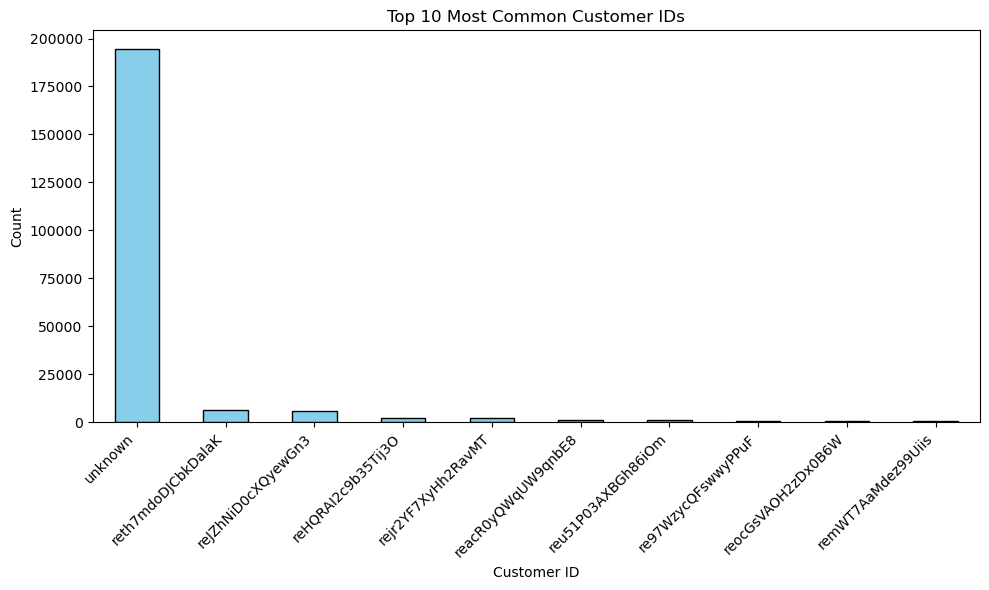

In [78]:
# Plot the top 10 most common customer_id values
customer_id_counts = df_retailer['customer_id'].value_counts()
top_customer_ids = customer_id_counts.head(10)

plt.figure(figsize=(10, 6))
top_customer_ids.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Most Common Customer IDs')
plt.xlabel('Customer ID')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [71]:
# Filter out rows where 'customer_id' is 'unknown'
filtered_customers = df_retailer[df_retailer['customer_id'] != 'unknown']

# Check the remaining customer data
print(f"Number of valid customers: {filtered_customers['customer_id'].nunique()}")
print(f"Total rows after filtering: {len(filtered_customers)}")

Number of valid customers: 1354583
Total rows after filtering: 9671519


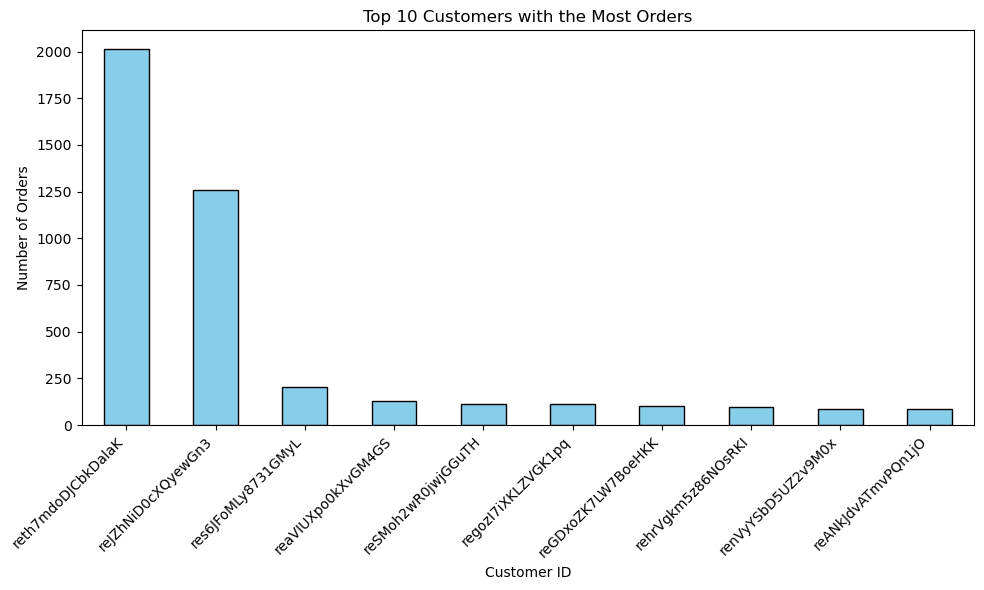

In [72]:
# Filter rows where 'event_name' is 'Order'
orders_data = df_retailer[df_retailer['event_name'] == 'Order']

# Count the number of 'Order' events per customer_id
order_counts = orders_data['customer_id'].value_counts()

# Exclude 'unknown' customer_id if necessary
order_counts = order_counts[order_counts.index != 'unknown']

# Get the top 10 customers with the most 'Order' events
top_order_customers = order_counts.head(10)

# Plot the top customers
plt.figure(figsize=(10, 6))
top_order_customers.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Customers with the Most Orders')
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

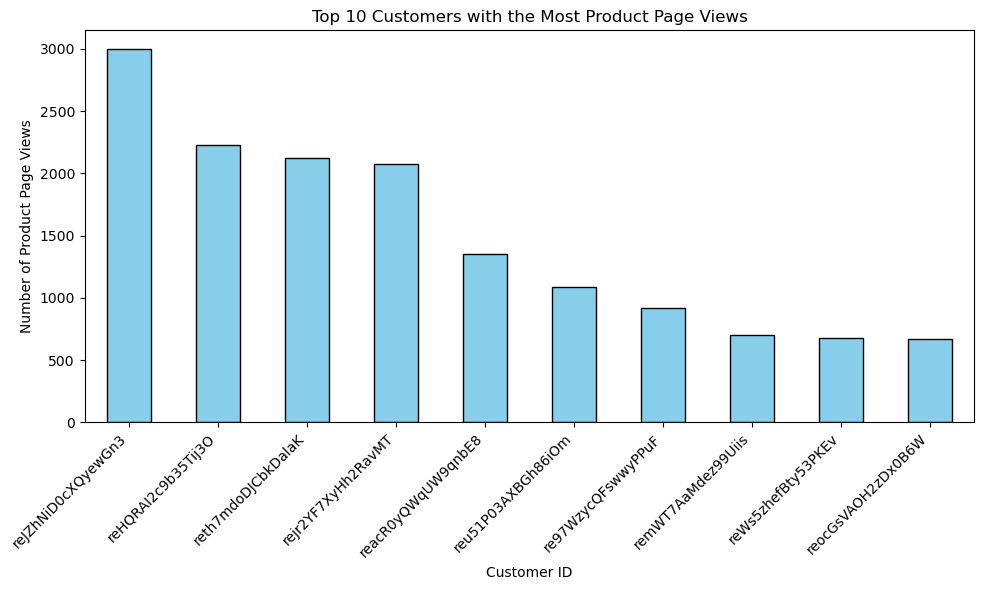

In [75]:
# Filter rows where 'event_name' is 'Order'
orders_data = df_retailer[df_retailer['event_name'] == 'Product Page View']

# Count the number of 'Order' events per customer_id
order_counts = orders_data['customer_id'].value_counts()

# Exclude 'unknown' customer_id if necessary
order_counts = order_counts[order_counts.index != 'unknown']

# Get the top 10 customers with the most 'Order' events
top_order_customers = order_counts.head(10)

# Plot the top customers
plt.figure(figsize=(10, 6))
top_order_customers.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Customers with the Most Product Page Views')
plt.xlabel('Customer ID')
plt.ylabel('Number of Product Page Views')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

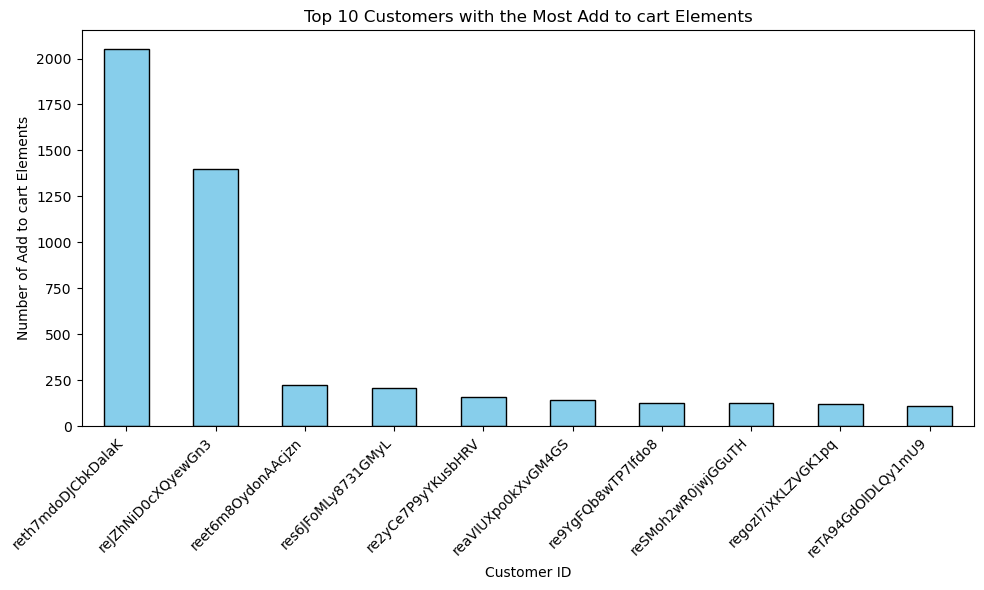

In [76]:
# Filter rows where 'event_name' is 'Order'
orders_data = df_retailer[df_retailer['event_name'] == 'Add to cart']

# Count the number of 'Order' events per customer_id
order_counts = orders_data['customer_id'].value_counts()

# Exclude 'unknown' customer_id if necessary
order_counts = order_counts[order_counts.index != 'unknown']

# Get the top 10 customers with the most 'Order' events
top_order_customers = order_counts.head(10)

# Plot the top customers
plt.figure(figsize=(10, 6))
top_order_customers.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Customers with the Most Add to cart Elements')
plt.xlabel('Customer ID')
plt.ylabel('Number of Add to cart Elements')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Types - Category